## Time to get your hands dirty! Supernova distances and redshifts (part 1)

Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova which are standard (or better, standardizable) candles.

Let's recall the definition of magnitude and the distance modulus (ah! the astronomers...)

$$
\mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5
$$

Here is the Hubble diagram for Type Ia supernovae (which are standard candels). The lines show the predictions for cosmologies with varying amounts of Ωm and ΩΛ. The observed points all lie above the line for a universe with zero Λ. The lower panel, with the slope caused by the inverse square law taken out, shows the difference between the predictions more clearly and shows why a model with ΩΛ > 0 is favored. 

These are some (synthetic but realistic; see textbook) supernova data.

####  Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of  polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

#### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

In [1]:
import warnings
warnings.simplefilter('ignore')
from astroML.datasets import generate_mu_z
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_predict
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
import numpy as np
from astroML.linear_model import NadarayaWatson
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ValidationCurveDisplay, LearningCurveDisplay
from sklearn.model_selection import RepeatedKFold

### 1. Data preparing

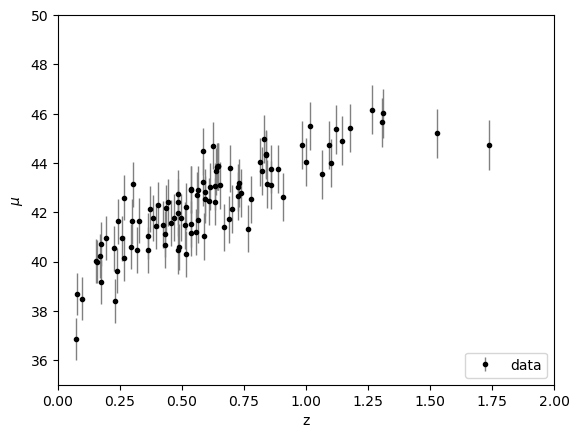

In [2]:
n = 100
z_sample, mu_sample, dmu = generate_mu_z(n, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

### 2. Linear Regression

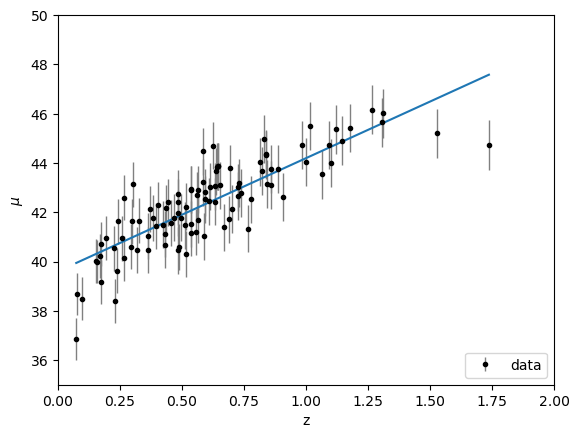

In [3]:
lin = LinearRegression()
lin.fit(z_sample[:, None], mu_sample, dmu)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.plot(np.sort(z_sample), lin.predict(np.sort(z_sample)[:, None]));

### 2. Basis Function Regression

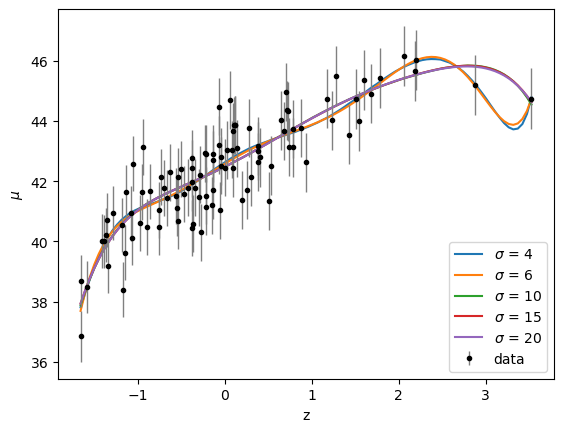

In [4]:
scaler = StandardScaler()
z_test = scaler.fit_transform(z_sample[:, None])
z_lin = np.linspace(min(z_test), max(z_test), 100)
sigmatest = [4,6,10,15,20]
for sigma in sigmatest:
  basis = BasisFunctionRegression('gaussian', mu=z_lin, sigma=sigma)
  basis.fit(z_test, mu_sample, dmu)
  plt.plot(z_lin, basis.predict(z_lin), label = r'$\sigma$ = '+str(sigma))

plt.errorbar(z_test, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right');

### 3. Nadaraya Watson Regression

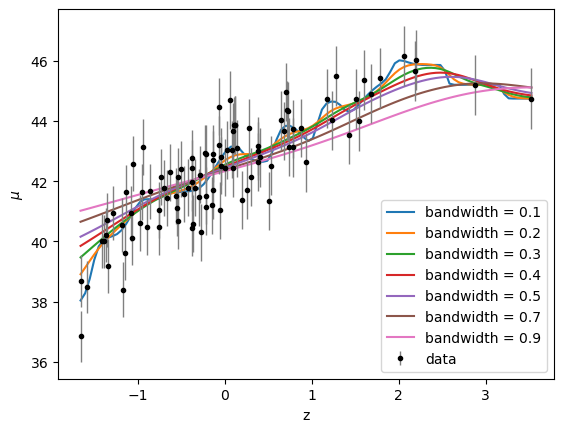

In [5]:
scaler = StandardScaler()
z_test = scaler.fit_transform(z_sample[:, None])
z_lin = np.linspace(min(z_test), max(z_test), 100)
bandwidth = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]
for h in bandwidth:
    model = NadarayaWatson(kernel='gaussian', h=h)
    model.fit(z_test,mu_sample)
    plt.plot(z_lin, model.predict(z_lin), label = 'bandwidth = '+str(h))

plt.errorbar(z_test, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right');

### 4. Polynomial Regression

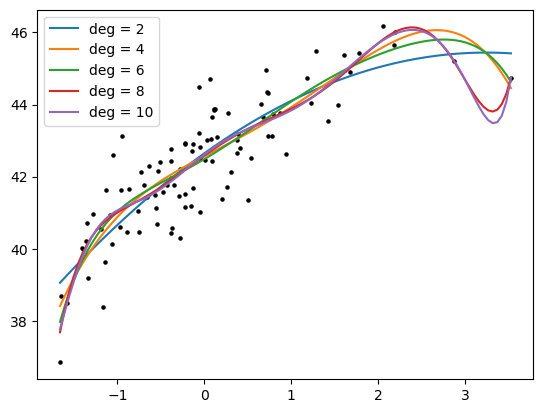

In [6]:
scaler = StandardScaler()
z_test = scaler.fit_transform(z_sample[:, None])
z_lin = np.linspace(min(z_test), max(z_test), n)
degree = [2,4,6,8,10]
for deg in degree:
    model = PolynomialRegression(deg) # fit degth degree polynomial
    model.fit(z_test, mu_sample)
    plt.plot(z_lin, model.predict(z_lin), label = 'deg = '+ str(deg))

plt.scatter(z_test, mu_sample, s = 5, color = 'black')
plt.legend()
plt.show()

Intuition: best fit is 2 or 4 degrees polynomial, while i'm underfitting when only 1 degree and overfitting with parameters higher than 6.

#### 4.1: K-folding 

Optimal parameter with K-fold (K = 10):  5


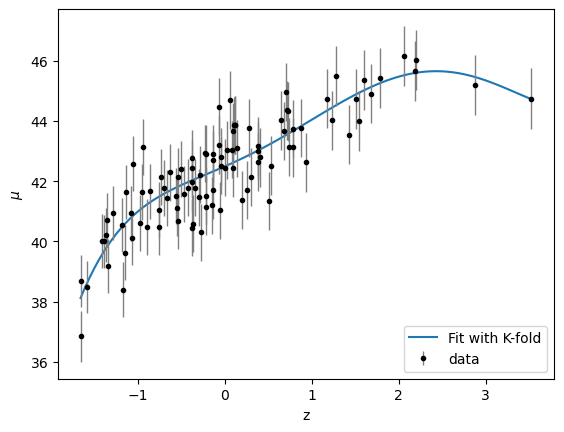

In [7]:
degrange = np.arange(1,10)
K = 10
grid = GridSearchCV(PolynomialRegression(), {'degree': degrange}, scoring = 'neg_root_mean_squared_error', cv= K, return_train_score = True)
grid.fit(z_test, mu_sample)
h_opt = grid.best_params_['degree']
print('Optimal parameter with K-fold (K = 10): ', h_opt)

model = PolynomialRegression(h_opt) # fit degth degree polynomial
model.fit(z_test, mu_sample)
plt.plot(z_lin, model.predict(z_lin), label = 'Fit with K-fold')
plt.errorbar(z_test, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right');

#### 4.2: Learning Curve

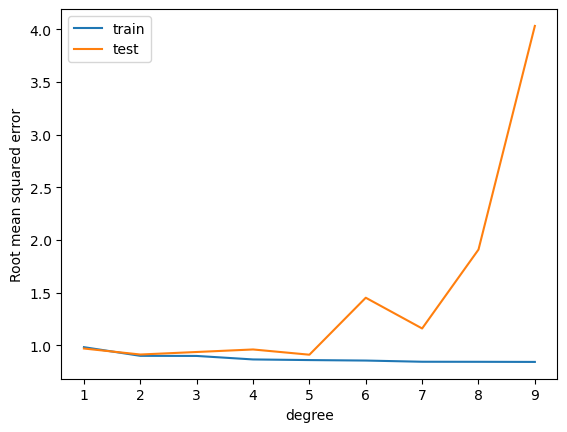

In [8]:
plt.plot(degrange, -grid.cv_results_['mean_train_score'], label = 'train')
plt.plot(degrange, -grid.cv_results_['mean_test_score'], label = 'test')
plt.xlabel('degree')
plt.ylabel('Root mean squared error')
plt.legend()
plt.show()

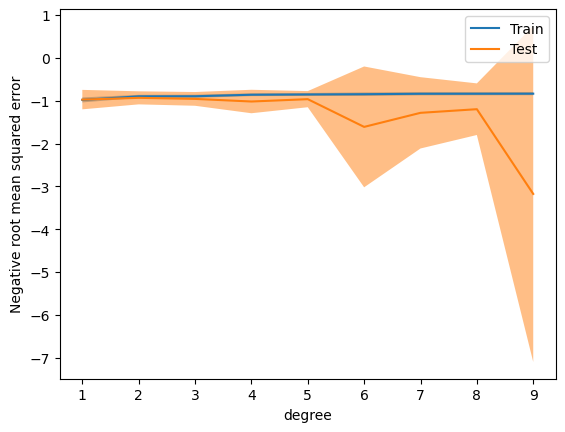

In [9]:
ValidationCurveDisplay.from_estimator(PolynomialRegression(), z_sample[:, None], mu_sample, param_name='degree', 
                                      param_range = degrange, scoring= 'neg_root_mean_squared_error')

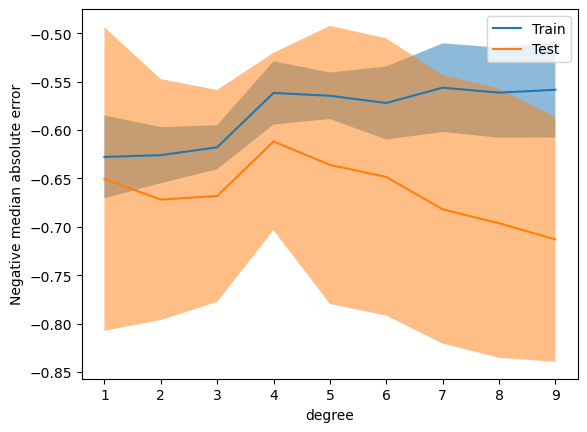

In [10]:
ValidationCurveDisplay.from_estimator(PolynomialRegression(), z_sample[:, None], mu_sample, param_name='degree', 
                                      param_range = degrange, scoring= 'neg_median_absolute_error')

'jaccard_macro', 'jaccard_samples', 'max_error', 'adjusted_rand_score', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 
'positive_likelihood_ratio', 'neg_mean_squared_log_error', 'adjusted_mutual_info_score', 'neg_mean_gamma_deviance', 'f1', 
'f1_micro', 'neg_mean_absolute_error', 'v_measure_score', 'neg_log_loss', 'recall_samples', 'roc_auc_ovr', 'recall_micro', 
'balanced_accuracy', 'recall', 'r2', 'accuracy', 'average_precision', 'precision', 'f1_macro', 'precision_macro', 'jaccard_micro', 
'precision_samples', 'roc_auc', 'roc_auc_ovo', 'jaccard_weighted', 'precision_weighted', 'f1_weighted', 'matthews_corrcoef', 'f1_samples', 
'completeness_score', 'neg_negative_likelihood_ratio', 'explained_variance', 'roc_auc_ovo_weighted', 'homogeneity_score', 'precision_micro', 
'neg_brier_score', 'recall_weighted', 'top_k_accuracy', 'neg_mean_poisson_deviance', 'jaccard', 'neg_mean_squared_error', 
'neg_mean_absolute_percentage_error', 'mutual_info_score', 'rand_score', 'roc_auc_ovr_weighted', 'normalized_mutual_info_score', 
'fowlkes_mallows_score', 'recall_macro'

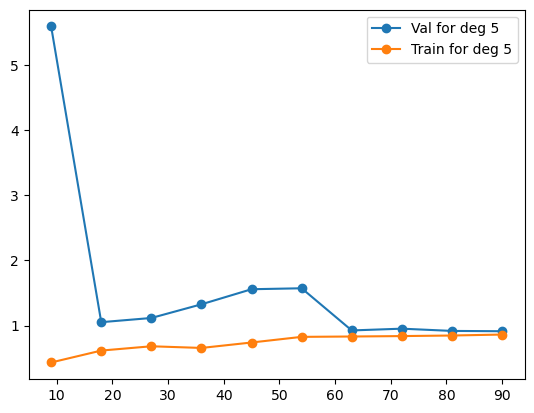

In [11]:
scaler = StandardScaler()
z_test = scaler.fit_transform(z_sample[:, None])
degree = [5]
x = 0
for deg in degree:
    model = PolynomialRegression(deg) # fit degth degree polynomial
    #model.fit(z_test, mu_sample)
    train_sizes, train_scores_mod, test_scores_mod = \
    learning_curve(model, z_sample[:, None], mu_sample, train_sizes=np.linspace(0.1, 1, 10), \
                   scoring="neg_root_mean_squared_error", cv = K)
    plt.plot(train_sizes[x:], -test_scores_mod.mean(1)[x:], 'o-', label="Val for deg "+str(deg))
    plt.plot(train_sizes[x:], -train_scores_mod.mean(1)[x:], 'o-', label="Train for deg "+str(deg))
plt.legend()
plt.show()

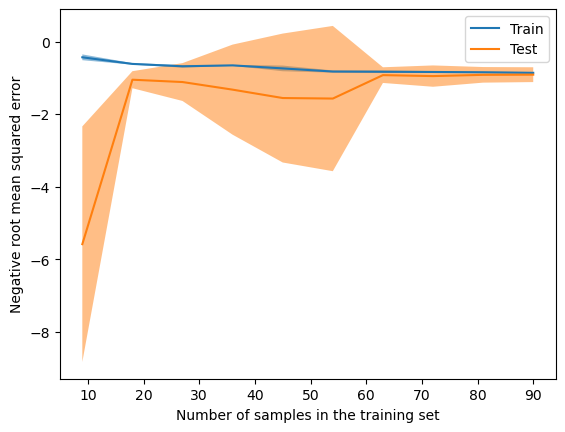

In [12]:
LearningCurveDisplay.from_estimator(PolynomialRegression(degree = 5), z_sample[:, None], mu_sample, train_sizes = np.linspace(0.1,1, 10),
                                      cv = K, scoring= 'neg_root_mean_squared_error')

In the learning curve, it is possible to see a jump in the validation curve. We can check what happens there?

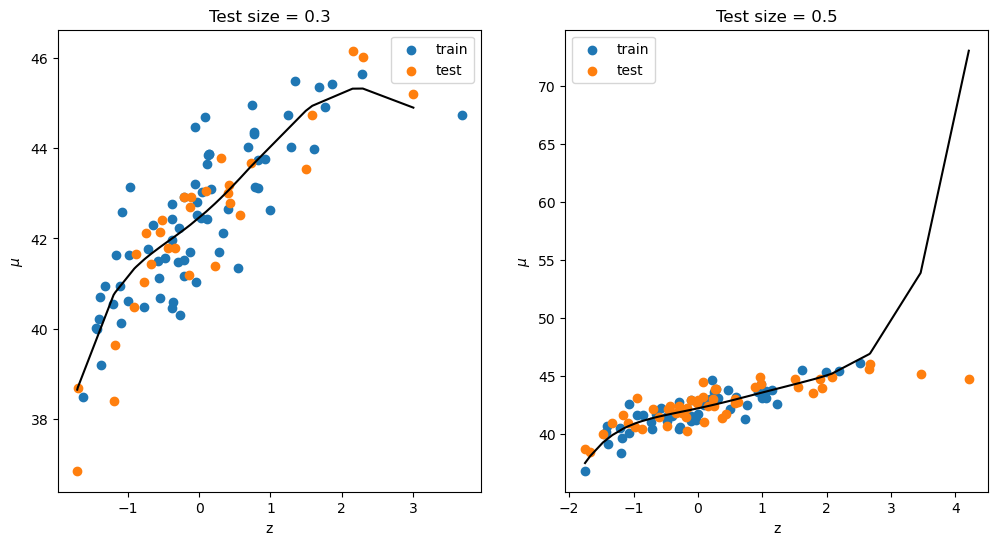

In [13]:
z_train, z_test, mu_train, mu_test = train_test_split(z_sample[:, None], mu_sample, test_size=0.3)
z_train_scaled = scaler.fit_transform(z_train)
z_test_scaled = scaler.transform(z_test)

model = PolynomialRegression(5) # fit degth degree polynomial
model.fit(z_train_scaled, mu_train)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
sns.lineplot(x = z_test_scaled[:, 0], y = model.predict(z_test_scaled),ax = ax1,  color = 'black')
ax1.scatter(z_train_scaled, mu_train, label = 'train')
ax1.scatter(z_test_scaled, mu_test, label = 'test')
ax1.set_xlabel('z')
ax1.set_ylabel(r'$\mu$')
ax1.set_title('Test size = 0.3')
ax1.legend()
z_train, z_test, mu_train, mu_test = train_test_split(z_sample[:, None], mu_sample, test_size=0.5)
z_train_scaled = scaler.fit_transform(z_train)
z_test_scaled = scaler.transform(z_test)

model = PolynomialRegression(5) # fit degth degree polynomial
model.fit(z_train_scaled, mu_train)

ax1 = fig.add_subplot(122)
sns.lineplot(x = z_test_scaled[:, 0], y = model.predict(z_test_scaled),ax = ax1,  color = 'black')
ax1.scatter(z_train_scaled, mu_train, label = 'train')
ax1.scatter(z_test_scaled, mu_test, label = 'test')
ax1.set_xlabel('z')
ax1.set_ylabel(r'$\mu$')
ax1.set_title('Test size = 0.5')
ax1.legend();

I guess the poorer performance on the validation set in the case of the test size = 0.5 is given by the fact that the greater size of the test subset is equivalent to a lesser probability to have in the training set of the values with higher redshift. This can be seen by the fact that on the left the presence of a high redshift data allows for the predictions to correctly predict the test data with high redshift values. Instead, on the right only the testing set contains high redshift values, therefore the model has troubles predicting the right values.

However, this did not convince me, because I would have to see this also in the other cases in which the testing subset has a greater size. I tried understanding what could lead to that bouncing and I noticed that if I didn't cross validate the learning curve the "hill" disappeared. Therefore, I think that what happens is that is actually the subdivision of the datasets due to the cross validation (that before I put K = 10) to give that effect. I tried to do a repeated K-folding and the hill does disappear.

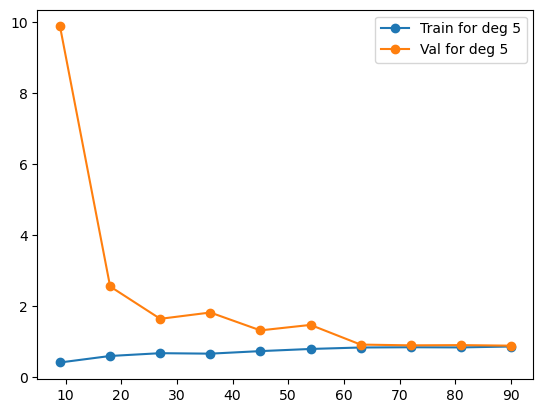

In [14]:
scaler = StandardScaler()
z_test = scaler.fit_transform(z_sample[:, None])
degree = [5]
x = 0
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
for deg in degree:
    model = PolynomialRegression(deg) # fit degth degree polynomial
    #model.fit(z_test, mu_sample)
    train_sizes, train_scores_mod, test_scores_mod = \
    learning_curve(model, z_sample[:, None], mu_sample, train_sizes=np.linspace(0.1, 1, 10), \
                   scoring="neg_root_mean_squared_error", cv = cv)    
    plt.plot(train_sizes[x:], -np.mean(train_scores_mod[x:], axis = 1), 'o-', label="Train for deg "+str(deg)) 
    plt.plot(train_sizes[x:], -np.mean(test_scores_mod[x:], axis = 1), 'o-', label="Val for deg "+str(deg))   
    
plt.legend()
plt.show()

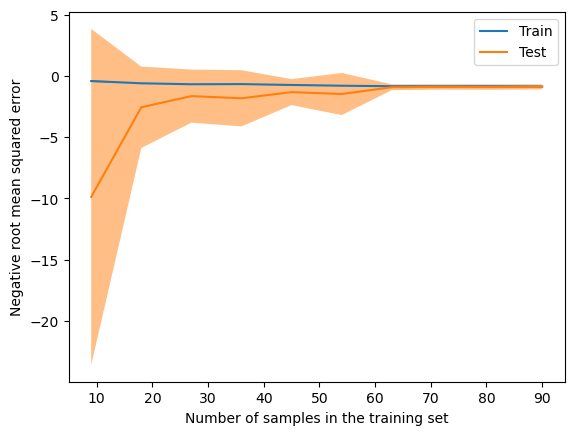

In [15]:
LearningCurveDisplay.from_estimator(PolynomialRegression(degree = 5), z_sample[:, None], mu_sample, train_sizes = np.linspace(0.1,1, 10),
                                      cv = cv, scoring= 'neg_root_mean_squared_error')

Still, I don't know why the hill appears at 0.4 and not already at 0.2, 0.3 - probably, the training size is so small that the model is not able to capture the data complexity yet?

#### 4.3: Prediction Comparison for different degrees

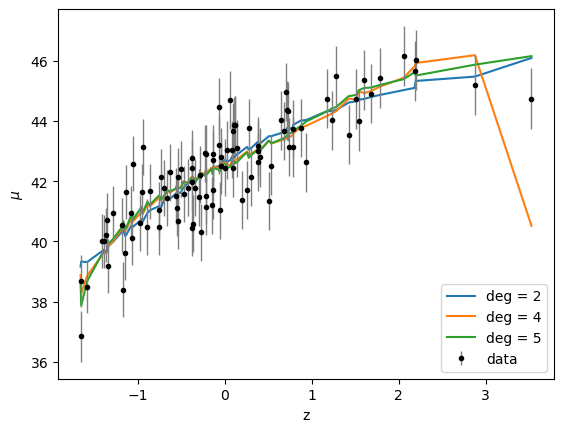

In [16]:
degree = [2,4,5]
for deg in degree:
    model = PolynomialRegression(deg) # fit degth degree polynomial
    model.fit(z_test, mu_sample)
    ypred = cross_val_predict(model, z_test, mu_sample, cv=K)
    sns.lineplot(x=z_test[:, 0], y = ypred, label = 'deg = '+str(deg))  #to have lineplot from sampling

plt.errorbar(z_test, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right');

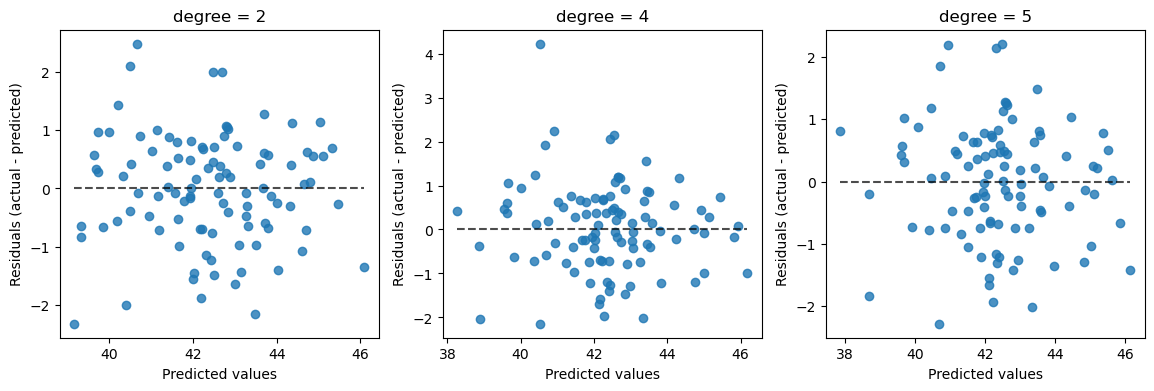

In [17]:
degree = [2,4,5]

fig = plt.figure(figsize =(14,4))

for idx, deg in enumerate(degree):
    model = PolynomialRegression(deg) # fit degth degree polynomial
    model.fit(z_test, mu_sample)
    ypred = cross_val_predict(model, z_test, mu_sample, cv=K)
    ax = fig.add_subplot(131+idx)
    ax.set_title('degree = '+str(deg))
    display = PredictionErrorDisplay.from_predictions(y_true=mu_sample, y_pred=ypred, ax = ax);

### 5. Different sample sizes

Here I check how the learning curve changes as a function of the samples size.

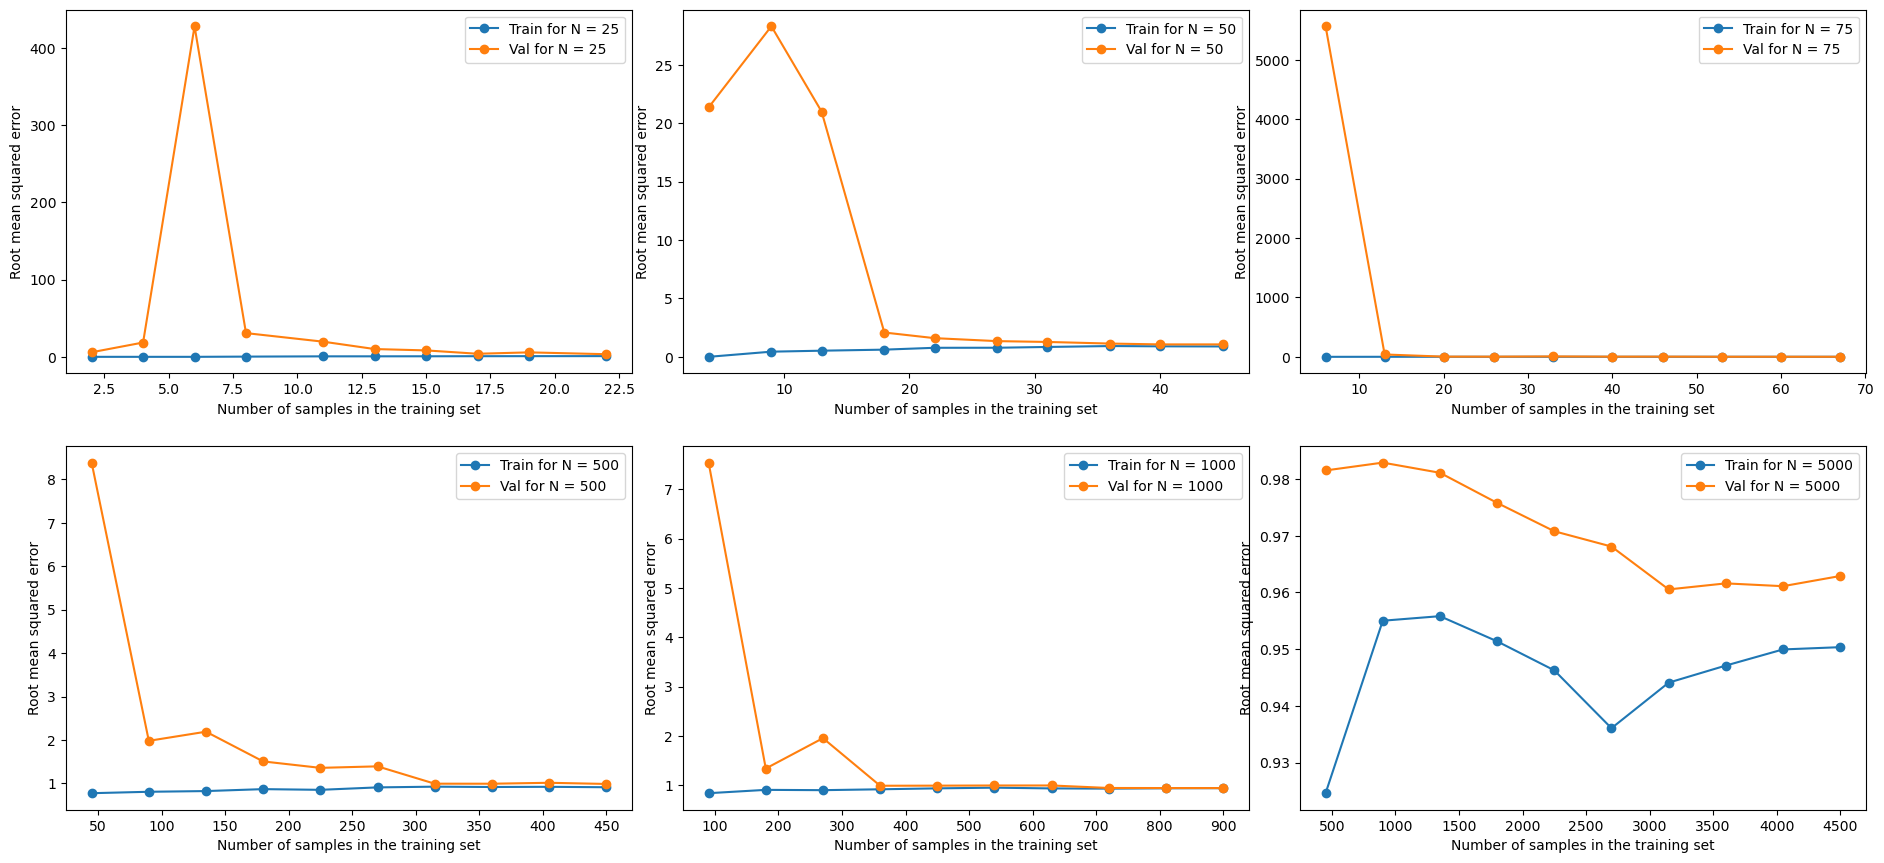

In [19]:
N = [25, 50, 75, 500, 1000, 5000]
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(wspace=0.09, bottom=0.15,
                    top=0.95, left=0.07, right=0.97)

for idx, num in enumerate(N):
    z_sample, mu_sample, dmu = generate_mu_z(num, random_state=1234)
    scaler = StandardScaler()
    z_test = scaler.fit_transform(z_sample[:, None])
    model = PolynomialRegression(5) # fit degth degree polynomial
    model.fit(z_test, mu_sample)
    train_sizes, train_scores_mod, test_scores_mod = \
    learning_curve(model, z_test, mu_sample, train_sizes=np.linspace(0.1, 1, 10), \
                   scoring="neg_root_mean_squared_error", cv=cv)
    ax = fig.add_subplot(231 + idx)
    ax.plot(train_sizes[x:], -train_scores_mod.mean(1)[x:], 'o-', label="Train for N = "+str(num))
    ax.plot(train_sizes[x:], -test_scores_mod.mean(1)[x:], 'o-', label="Val for N = "+str(num))
    ax.set_xlabel('Number of samples in the training set')
    ax.set_ylabel('Root mean squared error')
    plt.legend()
plt.show()

From these plots, we can see that some hills still appears in certain points.